# This notebook aims to develop a neural-network based classifier for the coffee bean dataset
## The technology of choice is pytorch

In [1]:
import torch
import pandas as pd
import os
from torchvision.io import read_image
from torch.utils.data import Dataset

bean_annotations = pd.read_csv("data/beans.csv")
bean_annotations.head()
DEFECT_CLASSES = dict(
    [
        (defect, index)
        for (index, defect) in enumerate(pd.unique(bean_annotations["defect_class"]))
    ]
)
DEFECT_CLASSES

{'burnt': 0,
 'normal': 1,
 'frag': 2,
 'under': 3,
 'quaker': 4,
 'insectOrMold': 5}

In [2]:
from torchvision.transforms import v2

transforms = {
    "train": v2.Compose(
        [
            v2.Resize(size=(400, 400)),
            v2.RandomHorizontalFlip(),
            v2.RandomRotation(
                degrees=(20, 340), fill=(255, 255, 255)
            ),  # Augment the data with random rotations, setting the background to white
            v2.ToDtype(
                torch.float32, scale=True
            ),  # Use float32 datatype to enable training on Apple silicon GPU
            v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]
    ),
    "test": v2.Compose(
        [
            v2.Resize(size=(400, 400)),
            v2.RandomRotation(
                degrees=(20, 340), fill=(255, 255, 255)
            ),  # Augment the data with random rotations, setting the background to white
            v2.ToDtype(torch.float32, scale=True),
            v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]
    ),
}

In [3]:
class RoastDefectsDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.bean_annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.bean_annotations)

    def get_labels(self):
        return self.bean_annotations["defect_class"]

    def __getitem__(self, item):
        if torch.is_tensor(item):
            item = item.toList()

        img_name = self.bean_annotations.iloc[item, 0]
        img_dir = "-".join(img_name.split("-")[0:4])
        img_path = os.path.join(self.root_dir, img_dir, img_name)
        image = read_image(img_path)

        if self.transform:
            image = self.transform(image)

        annotations = DEFECT_CLASSES[
            self.bean_annotations.iloc[item, 1:]["defect_class"]
        ]
        return image, annotations

In [4]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(
    bean_annotations,
    train_size=0.8,
    random_state=42,  # for repeatability
    stratify=bean_annotations["defect_class"],
)

In [5]:
train["defect_class"].value_counts()

defect_class
normal          1048
quaker           782
frag             237
under             83
burnt             40
insectOrMold      38
Name: count, dtype: int64

In [6]:
test["defect_class"].value_counts()

defect_class
normal          263
quaker          196
frag             59
under            21
burnt            10
insectOrMold      9
Name: count, dtype: int64

In [7]:
from torch.utils.data import DataLoader, SubsetRandomSampler
from torchsampler import ImbalancedDatasetSampler

data_train = RoastDefectsDataset(
    csv_file="data/beans.csv",
    root_dir="data/processed-whitebg",
    transform=transforms["train"],
)

data_test = RoastDefectsDataset(
    csv_file="data/beans.csv",
    root_dir="data/processed-whitebg",
    transform=transforms["test"],
)

train_sampler = ImbalancedDatasetSampler(
    data_train, labels=train["defect_class"], indices=list(train.index)
)
test_sampler = SubsetRandomSampler(list(test.index))


train_loader = DataLoader(data_train, sampler=train_sampler, batch_size=4)
test_loader = DataLoader(data_test, sampler=test_sampler, batch_size=1)

dataloaders = {"test": test_loader, "train": train_loader}
dataset_sizes = {"test": len(test), "train": len(train)}

In [8]:
device = "mps"  # Train on GPU

In [9]:
from sklearn.metrics import classification_report


def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    for epoch in range(num_epochs):
        print(f"Epoch {epoch}/{num_epochs - 1}")
        print("-" * 10)

        # Each epoch has a training and validation phase
        for phase in ["train", "test"]:
            if phase == "train":
                model.train()  # Set model to training mode
            else:
                model.eval()  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            all_labels = []
            all_preds = []

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                all_labels.extend(labels.tolist())

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    all_preds.extend(preds.tolist())

                    # backward + optimize only if in training phase
                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == "train":
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]
            print(f"Correct guesses in phase {phase}: {running_corrects}")
            print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")
            if phase == "test":
                print("Classification report for test dataset:")
                print(
                    classification_report(
                        all_labels,
                        all_preds,
                        target_names=DEFECT_CLASSES.keys(),
                        zero_division=0,
                    )
                )
            print()
    return model

In [12]:
from torchvision import models
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

model_ft = models.mobilenet_v2(weights="IMAGENET1K_V1", progress=False)
num_ftrs = model_ft.classifier[1].in_features
model_ft.classifier[1] = nn.Linear(num_ftrs, len(DEFECT_CLASSES))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.1)

In [13]:
model_ft = train_model(
    model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=40
)

Epoch 0/39
----------
Correct guesses in phase train: 1558
train Loss: 1.0837 Acc: 0.6993
Correct guesses in phase test: 394
test Loss: 1.1224 Acc: 0.7061
Classification report for test dataset:
              precision    recall  f1-score   support

       burnt       0.00      0.00      0.00        10
      normal       0.97      0.64      0.77       263
        frag       0.82      0.61      0.70        59
       under       0.00      0.00      0.00        21
      quaker       0.56      0.96      0.71       196
insectOrMold       0.00      0.00      0.00         9

    accuracy                           0.71       558
   macro avg       0.39      0.37      0.36       558
weighted avg       0.74      0.71      0.69       558


Epoch 1/39
----------
Correct guesses in phase train: 1652
train Loss: 0.9795 Acc: 0.7415
Correct guesses in phase test: 444
test Loss: 0.8772 Acc: 0.7957
Classification report for test dataset:
              precision    recall  f1-score   support

       burn

In [26]:
# model_ft.eval()
# for inputs, labels in dataloaders["test"]:
#     print(accuracy_score(torch.max(model_ft(inputs.to("mps")), 1)[1].cpu(), labels))

In [14]:
# torch.save(model_ft.state_dict(), "trained-models/mobilenet-pretrained-95-acc-36m16s-40epochs.pt")

In [7]:
from torchvision import models
from torch import nn

# device = "mps"
# model_ft = models.efficientnet_v2_s()
# num_ftrs = model_ft.classifier[1].in_features
# model_ft.classifier[1] = nn.Linear(num_ftrs, len(DEFECT_CLASSES))
# weights = torch.load("trained-models/efficientnet_v2_s_91_acc.pt")

In [15]:
# model_ft.load_state_dict(weights)
model_ft.to(device)
model_ft.eval()
all_labels = []
all_preds = []
with torch.no_grad():
    for inputs, labels in dataloaders["test"]:
        inputs = inputs.to(device)
        labels = labels.to(device)
        all_labels.extend(labels.tolist())
        outputs = model_ft(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.tolist())

In [16]:
from torcheval.metrics import MulticlassConfusionMatrix

matrix = MulticlassConfusionMatrix(len(DEFECT_CLASSES))
matrix.update(torch.tensor(all_preds), torch.tensor(all_labels))

confs = matrix.compute()

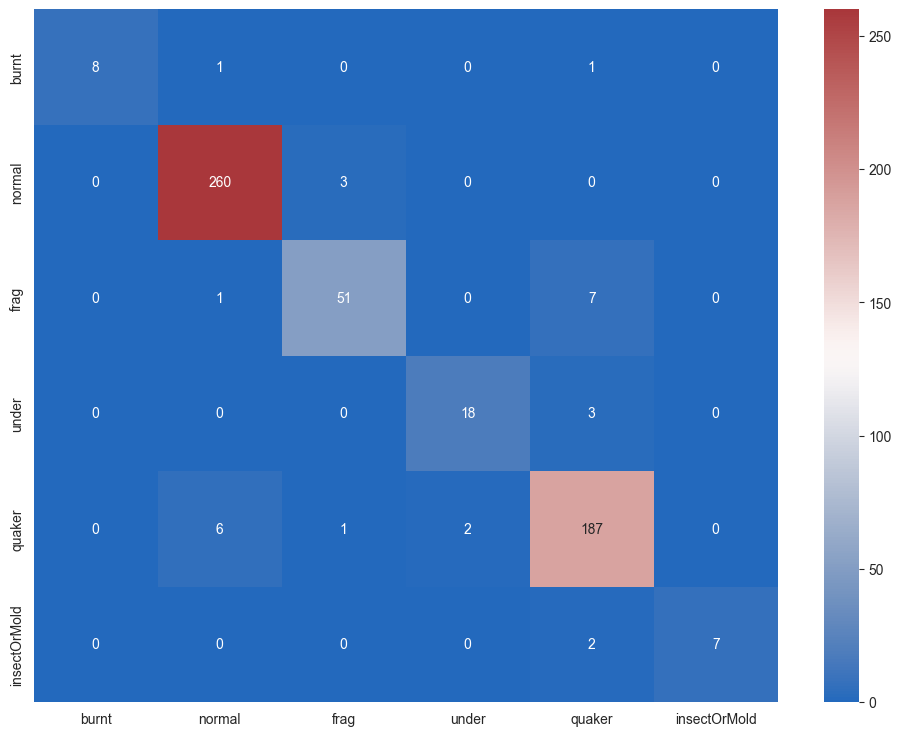

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(
    confs,
    annot=True,  # write values in cells
    cmap="vlag",
    xticklabels=DEFECT_CLASSES.keys(),
    yticklabels=DEFECT_CLASSES.keys(),
    ax=ax,
    fmt="g",  # annotate without using scientific notation
)
plt.savefig("trained-models/confusion-matrices/mobilenet-95acc.png")

In [80]:
print(classification_report(all_labels, all_preds, digits=3))

              precision    recall  f1-score   support

           0      1.000     0.600     0.750        10
           1      0.981     0.977     0.979       263
           2      0.898     0.898     0.898        59
           3      0.792     0.905     0.844        21
           4      0.924     0.929     0.926       196
           5      0.600     0.667     0.632         9

    accuracy                          0.937       558
   macro avg      0.866     0.829     0.838       558
weighted avg      0.939     0.937     0.937       558
